In [1]:
from generate_dataset import *

In [2]:
import time
import random
import logging

import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score

a:\python3.6\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
# 定义SVM模型，传入 array 的矩阵形式
class SVM(object):

    def __init__(self, kernel='linear',epsilon = 0.001):###################
        self.kernel = kernel
        self.epsilon = epsilon

    def _init_parameters(self, features, labels):###################
        '''
        初始化一些参数
        '''
        self.X = features
        self.Y = labels
        
        self.C = 1000
        self.b = 0.0
        self.n = features.shape[1] #实例的维度 
        self.N = features.shape[0]#实例数
        self.alpha =np.array([0.0]*self.N)  #随机初始化 alpha 将其定义在C范围内
        self.E = np.array([self._E_(i) for i in range(self.N)])
        self.index = np.array([i for i in range(self.N)])
        
        self.Max_Interation = 2000


    def _satisfy_KKT(self, i): #
        ygx = self.Y[i] * self._g_(i)
        if ygx >= 1:
            return abs(self.alpha[i])<self.epsilon
        elif ygx <= 1:
            return abs(self.alpha[i]-self.C)<self.epsilon
        else:
            return abs(ygx-1) <= self.epsilon

    def is_stop(self):
        for i in range(self.N):
            satisfy = self._satisfy_KKT(i)
            if not satisfy:
                return False
        return True

    def _select_two_parameters(self):  ####################
        '''
        按照书上7.4.2选择两个变量
        '''
        first_index = -1
        i1_list_1 = np.intersect1d(np.where(self.alpha > 0),np.where(self.alpha < self.C))
        i1_list_2 = np.array(list(set(self.index.tolist()) - set(i1_list_1.tolist())))
        for i in i1_list_1:
            if not self._satisfy_KKT(i):
                first_index = i
                break
        if first_index == -1:
            for i in i1_list_2:
                if not self._satisfy_KKT(i):
                    first_index = i
                    break        
        E1 = self.E[first_index]     
        second_index = np.argmax(np.absolute(E1 - self.E))
    
        return first_index, second_index

    def _K_(self, x1, x2):    #########################
        '''
        核函数
        '''
        if self.kernel == 'linear':
            return np.dot(x1,x2)
        if self.kernel == 'poly':
            return (np.dot(x1,x2)+1)**3
        print('没有定义核函数')
        return 0

    def _g_(self, i):   ###########################
        '''
        公式(7.104)
        '''
        return sum(self.alpha * self.Y *  self._K_(self.X, self.X[i])) + self.b
        

    def _E_(self, i):     ##########################
        '''
        公式(7.105)
        '''
        return self._g_(i) - self.Y[i]

    


    def train(self, features, labels):

        self._init_parameters(features, labels)

        for times in range(self.Max_Interation):
            if self.is_stop():
                return
            
            logging.debug('iterater %d' % times)

            i1, i2 = self._select_two_parameters()

            if self.Y[i1] == self.Y[i2]:
                L = max(0, self.alpha[i2] + self.alpha[i1] - self.C)
                H = min(self.C, self.alpha[i2] + self.alpha[i1])
            else:
                L = max(0, self.alpha[i2] - self.alpha[i1])
                H = min(self.C, self.C + self.alpha[i2] - self.alpha[i1])

            E1 = self.E[i1]
            E2 = self.E[i2]
            eta = self._K_(self.X[i1], self.X[i1]) + self._K_(self.X[i2], self.X[i2]) - 2 * self._K_(self.X[i1], self.X[i2])     # 公式(7.107)

            alpha2_new_unc = self.alpha[i2] + self.Y[i2] * (E1 - E2) / eta        # 公式(7.106)

            # 公式(7.108)
            alph2_new = 0
            if alpha2_new_unc > H:
                alph2_new = H
            elif alpha2_new_unc < L:
                alph2_new = L
            else:
                alph2_new = alpha2_new_unc

            # 公式(7.109)
            alph1_new = self.alpha[i1] + self.Y[i1] * self.Y[i2] * (self.alpha[i2] - alph2_new)

            # 公式(7.115) 及 公式(7.116)
            b1_new = -E1 - self.Y[i1] * self._K_(self.X[i1], self.X[i1]) * (alph1_new - self.alpha[i1]) - self.Y[i2] * self._K_(self.X[i2], self.X[i1]) * (alph2_new - self.alpha[i2]) + self.b
            b2_new = -E2 - self.Y[i1] * self._K_(self.X[i1], self.X[i2]) * (alph1_new - self.alpha[i1]) - self.Y[i2] * self._K_(self.X[i2], self.X[i2]) * (alph2_new - self.alpha[i2]) + self.b

            if alph1_new > 0 and alph1_new < self.C:
                b_new = b1_new
            elif alph2_new > 0 and alph2_new < self.C:
                b_new = b2_new
            else:
                b_new = (b1_new + b2_new) / 2

            self.alpha[i1] = alph1_new
            self.alpha[i2] = alph2_new
            self.b = b_new

            self.E[i1] = self._E_(i1)
            self.E[i2] = self._E_(i2)
            

    def _predict_(self,feature): 
        if sum(self.alpha*self.Y*self._K_(self.X, feature)) + self.b > 0:
            return 1
        return -1

    def predict(self,features):
        results = []
        for feature in features:
            results.append(self._predict_(feature))
        return results

a:\python3.6\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


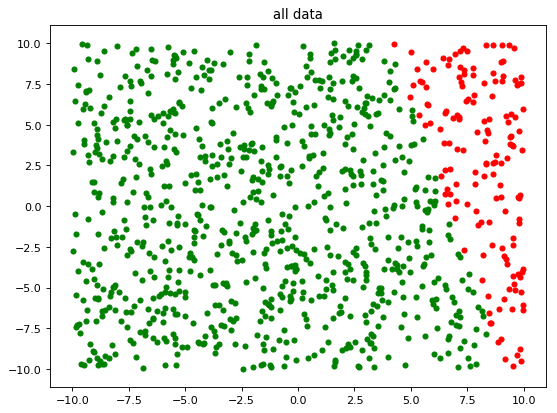

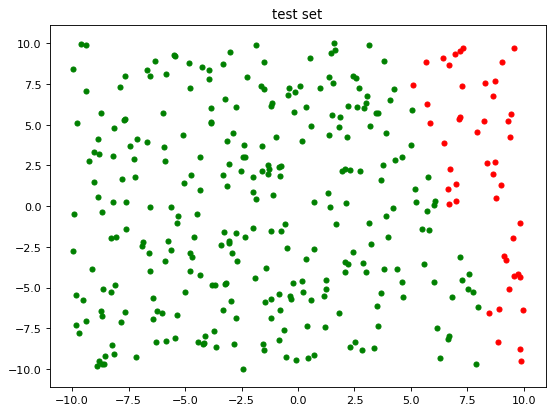

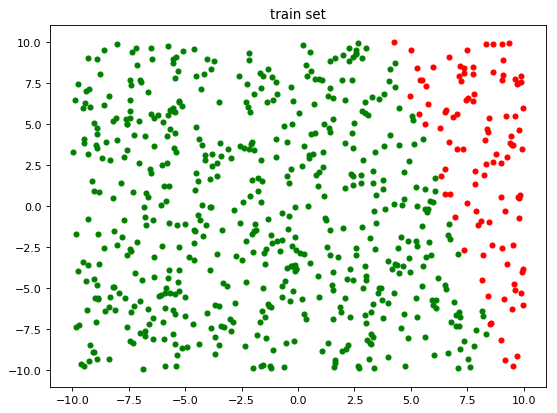

In [4]:
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

# 选取 2/3 数据作为训练集， 1/3 数据作为测试集
train_features, train_labels, test_features, test_labels = generate_dataset(1000,visualization=True)

In [5]:
np.array(train_features)

array([[ 8.65434209,  9.87544337],
       [-0.10936147, -3.85661208],
       [-4.92151904, -8.61729164],
       ...,
       [-4.20083096, -1.80647629],
       [ 2.43578835, -4.51913808],
       [ 9.59610453, -5.12177113]])

In [18]:
svm = SVM()
svm.train(np.array(train_features), np.array(train_labels))

DEBUG:root:iterater 0
DEBUG:root:iterater 1
DEBUG:root:iterater 2
DEBUG:root:iterater 3
DEBUG:root:iterater 4
DEBUG:root:iterater 5
DEBUG:root:iterater 6
DEBUG:root:iterater 7
DEBUG:root:iterater 8
DEBUG:root:iterater 9
DEBUG:root:iterater 10
DEBUG:root:iterater 11
DEBUG:root:iterater 12
DEBUG:root:iterater 13
DEBUG:root:iterater 14
DEBUG:root:iterater 15
DEBUG:root:iterater 16
DEBUG:root:iterater 17
DEBUG:root:iterater 18
DEBUG:root:iterater 19
DEBUG:root:iterater 20
DEBUG:root:iterater 21
DEBUG:root:iterater 22
DEBUG:root:iterater 23
DEBUG:root:iterater 24
DEBUG:root:iterater 25
DEBUG:root:iterater 26
DEBUG:root:iterater 27
DEBUG:root:iterater 28
DEBUG:root:iterater 29
DEBUG:root:iterater 30
DEBUG:root:iterater 31
DEBUG:root:iterater 32
DEBUG:root:iterater 33
DEBUG:root:iterater 34
DEBUG:root:iterater 35
DEBUG:root:iterater 36
DEBUG:root:iterater 37
DEBUG:root:iterater 38
DEBUG:root:iterater 39
DEBUG:root:iterater 40
DEBUG:root:iterater 41
DEBUG:root:iterater 42
DEBUG:root:iterater 4

DEBUG:root:iterater 346
DEBUG:root:iterater 347
DEBUG:root:iterater 348
DEBUG:root:iterater 349
DEBUG:root:iterater 350
DEBUG:root:iterater 351
DEBUG:root:iterater 352
DEBUG:root:iterater 353
DEBUG:root:iterater 354
DEBUG:root:iterater 355
DEBUG:root:iterater 356
DEBUG:root:iterater 357
DEBUG:root:iterater 358
DEBUG:root:iterater 359
DEBUG:root:iterater 360
DEBUG:root:iterater 361
DEBUG:root:iterater 362
DEBUG:root:iterater 363
DEBUG:root:iterater 364
DEBUG:root:iterater 365
DEBUG:root:iterater 366
DEBUG:root:iterater 367
DEBUG:root:iterater 368
DEBUG:root:iterater 369
DEBUG:root:iterater 370
DEBUG:root:iterater 371
DEBUG:root:iterater 372
DEBUG:root:iterater 373
DEBUG:root:iterater 374
DEBUG:root:iterater 375
DEBUG:root:iterater 376
DEBUG:root:iterater 377
DEBUG:root:iterater 378
DEBUG:root:iterater 379
DEBUG:root:iterater 380
DEBUG:root:iterater 381
DEBUG:root:iterater 382
DEBUG:root:iterater 383
DEBUG:root:iterater 384
DEBUG:root:iterater 385
DEBUG:root:iterater 386
DEBUG:root:itera

DEBUG:root:iterater 688
DEBUG:root:iterater 689
DEBUG:root:iterater 690
DEBUG:root:iterater 691
DEBUG:root:iterater 692
DEBUG:root:iterater 693
DEBUG:root:iterater 694
DEBUG:root:iterater 695
DEBUG:root:iterater 696
DEBUG:root:iterater 697
DEBUG:root:iterater 698
DEBUG:root:iterater 699
DEBUG:root:iterater 700
DEBUG:root:iterater 701
DEBUG:root:iterater 702
DEBUG:root:iterater 703
DEBUG:root:iterater 704
DEBUG:root:iterater 705
DEBUG:root:iterater 706
DEBUG:root:iterater 707
DEBUG:root:iterater 708
DEBUG:root:iterater 709
DEBUG:root:iterater 710
DEBUG:root:iterater 711
DEBUG:root:iterater 712
DEBUG:root:iterater 713
DEBUG:root:iterater 714
DEBUG:root:iterater 715
DEBUG:root:iterater 716
DEBUG:root:iterater 717
DEBUG:root:iterater 718
DEBUG:root:iterater 719
DEBUG:root:iterater 720
DEBUG:root:iterater 721
DEBUG:root:iterater 722
DEBUG:root:iterater 723
DEBUG:root:iterater 724
DEBUG:root:iterater 725
DEBUG:root:iterater 726
DEBUG:root:iterater 727
DEBUG:root:iterater 728
DEBUG:root:itera

DEBUG:root:iterater 1029
DEBUG:root:iterater 1030
DEBUG:root:iterater 1031
DEBUG:root:iterater 1032
DEBUG:root:iterater 1033
DEBUG:root:iterater 1034
DEBUG:root:iterater 1035
DEBUG:root:iterater 1036
DEBUG:root:iterater 1037
DEBUG:root:iterater 1038
DEBUG:root:iterater 1039
DEBUG:root:iterater 1040
DEBUG:root:iterater 1041
DEBUG:root:iterater 1042
DEBUG:root:iterater 1043
DEBUG:root:iterater 1044
DEBUG:root:iterater 1045
DEBUG:root:iterater 1046
DEBUG:root:iterater 1047
DEBUG:root:iterater 1048
DEBUG:root:iterater 1049
DEBUG:root:iterater 1050
DEBUG:root:iterater 1051
DEBUG:root:iterater 1052
DEBUG:root:iterater 1053
DEBUG:root:iterater 1054
DEBUG:root:iterater 1055
DEBUG:root:iterater 1056
DEBUG:root:iterater 1057
DEBUG:root:iterater 1058
DEBUG:root:iterater 1059
DEBUG:root:iterater 1060
DEBUG:root:iterater 1061
DEBUG:root:iterater 1062
DEBUG:root:iterater 1063
DEBUG:root:iterater 1064
DEBUG:root:iterater 1065
DEBUG:root:iterater 1066
DEBUG:root:iterater 1067
DEBUG:root:iterater 1068


DEBUG:root:iterater 1357
DEBUG:root:iterater 1358
DEBUG:root:iterater 1359
DEBUG:root:iterater 1360
DEBUG:root:iterater 1361
DEBUG:root:iterater 1362
DEBUG:root:iterater 1363
DEBUG:root:iterater 1364
DEBUG:root:iterater 1365
DEBUG:root:iterater 1366
DEBUG:root:iterater 1367
DEBUG:root:iterater 1368
DEBUG:root:iterater 1369
DEBUG:root:iterater 1370
DEBUG:root:iterater 1371
DEBUG:root:iterater 1372
DEBUG:root:iterater 1373
DEBUG:root:iterater 1374
DEBUG:root:iterater 1375
DEBUG:root:iterater 1376
DEBUG:root:iterater 1377
DEBUG:root:iterater 1378
DEBUG:root:iterater 1379
DEBUG:root:iterater 1380
DEBUG:root:iterater 1381
DEBUG:root:iterater 1382
DEBUG:root:iterater 1383
DEBUG:root:iterater 1384
DEBUG:root:iterater 1385
DEBUG:root:iterater 1386
DEBUG:root:iterater 1387
DEBUG:root:iterater 1388
DEBUG:root:iterater 1389
DEBUG:root:iterater 1390
DEBUG:root:iterater 1391
DEBUG:root:iterater 1392
DEBUG:root:iterater 1393
DEBUG:root:iterater 1394
DEBUG:root:iterater 1395
DEBUG:root:iterater 1396


DEBUG:root:iterater 1685
DEBUG:root:iterater 1686
DEBUG:root:iterater 1687
DEBUG:root:iterater 1688
DEBUG:root:iterater 1689
DEBUG:root:iterater 1690
DEBUG:root:iterater 1691
DEBUG:root:iterater 1692
DEBUG:root:iterater 1693
DEBUG:root:iterater 1694
DEBUG:root:iterater 1695
DEBUG:root:iterater 1696
DEBUG:root:iterater 1697
DEBUG:root:iterater 1698
DEBUG:root:iterater 1699
DEBUG:root:iterater 1700
DEBUG:root:iterater 1701
DEBUG:root:iterater 1702
DEBUG:root:iterater 1703
DEBUG:root:iterater 1704
DEBUG:root:iterater 1705
DEBUG:root:iterater 1706
DEBUG:root:iterater 1707
DEBUG:root:iterater 1708
DEBUG:root:iterater 1709
DEBUG:root:iterater 1710
DEBUG:root:iterater 1711
DEBUG:root:iterater 1712
DEBUG:root:iterater 1713
DEBUG:root:iterater 1714
DEBUG:root:iterater 1715
DEBUG:root:iterater 1716
DEBUG:root:iterater 1717
DEBUG:root:iterater 1718
DEBUG:root:iterater 1719
DEBUG:root:iterater 1720
DEBUG:root:iterater 1721
DEBUG:root:iterater 1722
DEBUG:root:iterater 1723
DEBUG:root:iterater 1724


In [19]:
# 训练误差
train_predict = svm.predict(train_features)
score = accuracy_score(train_labels,train_predict)
score

0.9370314842578711

In [20]:
# 检验误差
test_predict = svm.predict(test_features)
score = accuracy_score(test_labels,test_predict)
score

0.9429429429429429

0.9459459459459459

In [91]:
a = np.array([1,2,-4,2,-5,1])

In [92]:
a

array([ 1,  2, -4,  2, -5,  1])

In [93]:
np.absolute(a)

array([1, 2, 4, 2, 5, 1])

In [88]:
(1+a)

array([[1.46867419, 0.        , 1.37849192, 1.25928441, 1.73016766]])

In [8]:
np.array((np.random.rand(1,5)*2).tolist()[0])

array([1.97642885, 1.56811652, 0.8648812 , 1.37342521, 0.1250321 ])